[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Talel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Shape: (28332, 24)
Columns: ['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand', 'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer', 'manufacturerNumber', 'reviews.date', 'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs']
Missing values:\n id                         0
dateAdded                  0
dateUpdated                0
name                       0
asins                      0
brand                      0
categories                 0
primaryCategories          0
imageURLs                  0
keys                       0
manufacturer               0
manufacturerNumber         0
reviews.date               0
reviews.dateSeen           0
reviews.didPurchase    28323
reviews.doRecommend    12246
reviews.id             28291
reviews.numHelpful     12217
reviews.rating             0
reviews.sourceURLs     

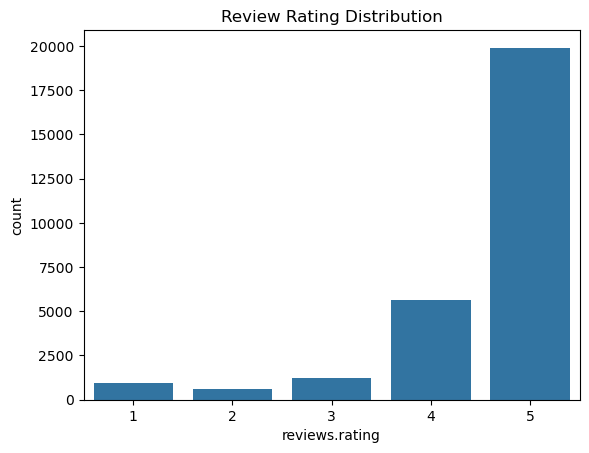

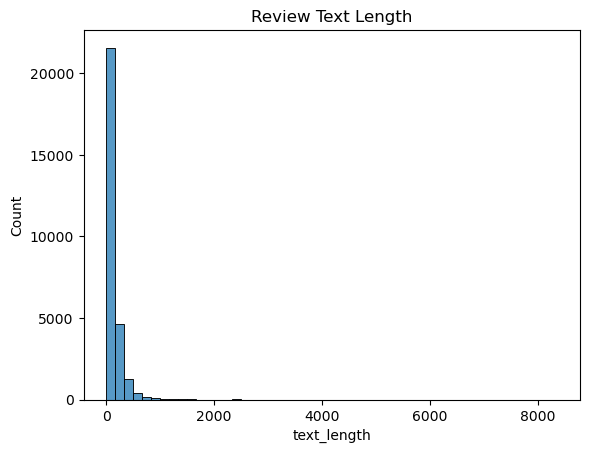

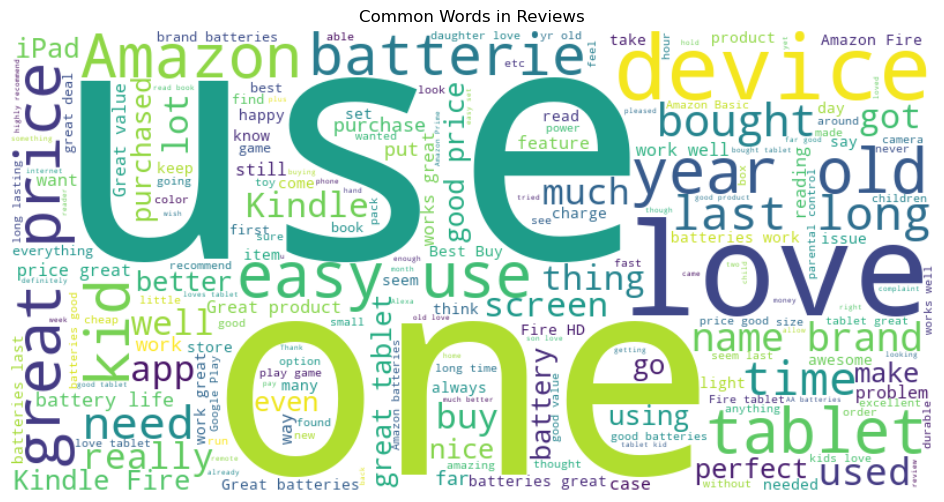

In [4]:
## 🧰 Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import re

nltk.download('stopwords')
from nltk.corpus import stopwords

## 📥 Load Data
df = pd.read_csv('../data/amazon_reviews.csv')
df.head()

## 🔍 Initial Exploration
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Missing values:\\n", df.isna().sum())

## ✂️ Select relevant columns
df = df[['reviews.rating', 'reviews.text', 'reviews.title', 'reviews.date', 'name', 'primaryCategories']].copy()
df = df.dropna(subset=['reviews.text', 'reviews.rating'])

## ✨ Basic Feature Engineering
df['text_length'] = df['reviews.text'].apply(len)
df['word_count'] = df['reviews.text'].apply(lambda x: len(str(x).split()))

## 📊 Rating distribution
sns.countplot(x='reviews.rating', data=df)
plt.title("Review Rating Distribution")
plt.show()

## 📊 Review length distribution
sns.histplot(df['text_length'], bins=50)
plt.title("Review Text Length")
plt.show()

## ☁️ WordCloud for all reviews
text = ' '.join(df['reviews.text'].dropna().astype(str).tolist())
stop_words = set(stopwords.words('english'))
cleaned = ' '.join([word for word in re.sub(r'[^a-zA-Z]', ' ', text).split() if word.lower() not in stop_words])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cleaned)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Reviews")
plt.show()






In [5]:
## 💾 Save cleaned version (optional for modeling)
df.to_csv('../data/amazon_reviews_cleaned.csv', index=False)

              precision    recall  f1-score   support

           0       0.85      0.90      0.88       558
           1       0.90      0.85      0.87       557

    accuracy                           0.87      1115
   macro avg       0.87      0.87      0.87      1115
weighted avg       0.87      0.87      0.87      1115



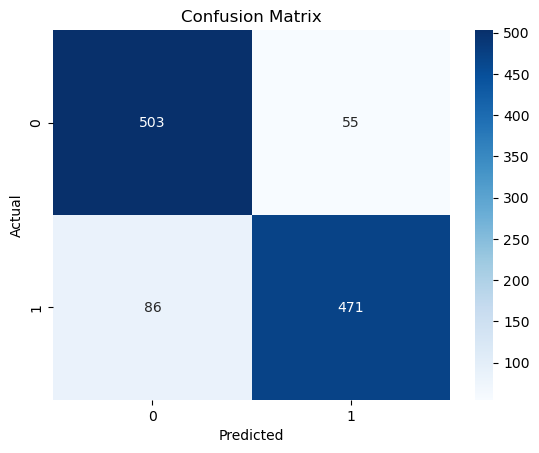

In [7]:
# 📘 02_sentiment_model.ipynb

## 🧰 Imports
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## 📥 Load Cleaned Data
df = pd.read_csv('../data/amazon_reviews_cleaned.csv')
df = df.dropna(subset=['reviews.text', 'reviews.rating'])

## 🧠 Define Sentiment
# 1–3 → negative, 4–5 → positive
df['sentiment'] = df['reviews.rating'].apply(lambda x: 1 if x >= 4 else 0)

## ✂️ Text Cleaning Function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\\n", " ", text)
    text = re.sub(r"http\\S+", "", text)
    text = re.sub(r"[^a-zA-Z ]", "", text)
    text = re.sub(r"\\s+", " ", text)
    return text.strip()

df['clean_text'] = df['reviews.text'].apply(clean_text)

## ✂️ Reduce Class Imbalance (optional)
# Sample from class 1 to balance the dataset
positive = df[df['sentiment'] == 1]
negative = df[df['sentiment'] == 0]
df_balanced = pd.concat([positive.sample(len(negative), random_state=42), negative])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

## ✏️ TF-IDF Vectorization
X = df_balanced['clean_text']
y = df_balanced['sentiment']

tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
X_vec = tfidf.fit_transform(X)

## 🔀 Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

## 🤖 Model Training
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

## 📈 Evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

## 🔍 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [10]:
import joblib

# From your previous notebook
joblib.dump(tfidf, '../dashboard/tfidf_vectorizer.joblib')
joblib.dump(model, '../dashboard/logistic_model.joblib')

['../dashboard/logistic_model.joblib']

Review Text:
This is my third Kindle Fire and it improves each time. Colors are crisper and best of all it stays charged a lot longer.
Predicted Sentiment: 1


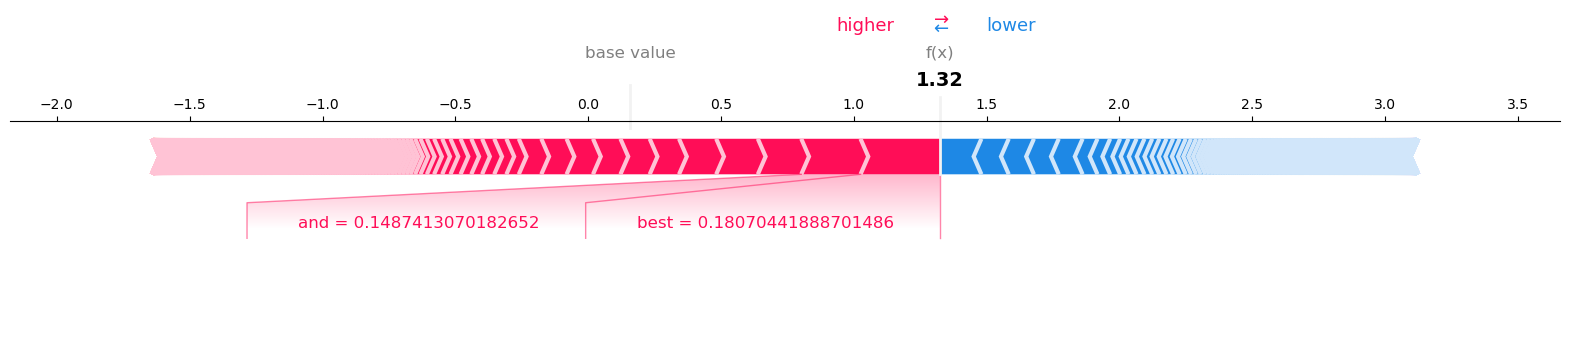

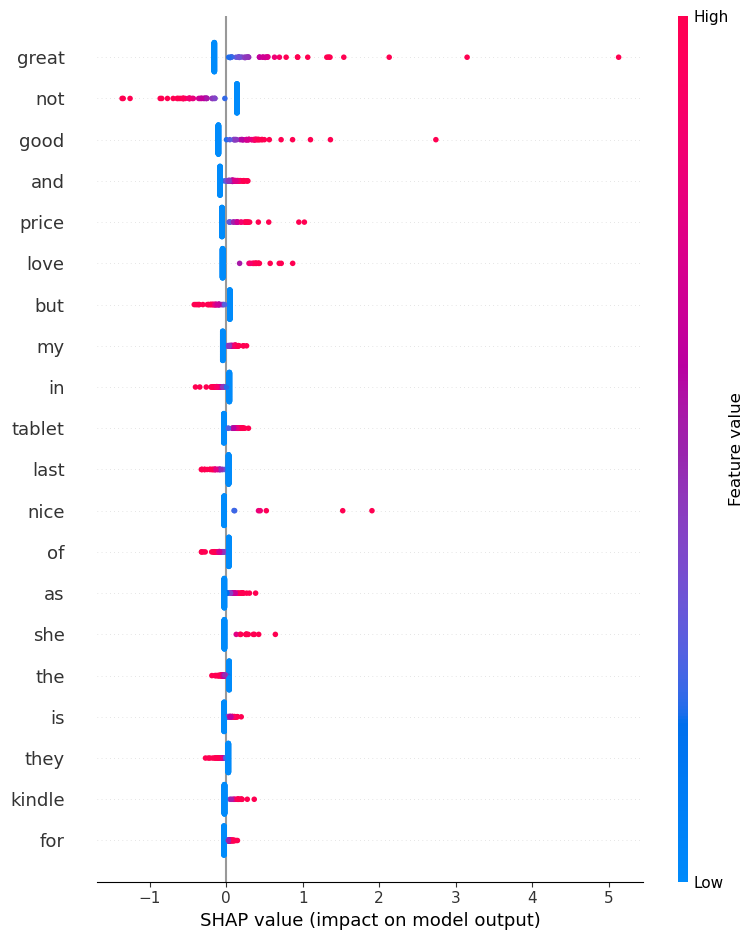

In [18]:
# 📘 03_shap_explanation.ipynb

## 🧰 Imports
import pandas as pd
import joblib
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# 📥 Load vectorizer and model
tfidf = joblib.load('../dashboard/tfidf_vectorizer.joblib')
model = joblib.load('../dashboard/logistic_model.joblib')

# 📄 Load processed data
df = pd.read_csv('../data/amazon_reviews_cleaned.csv')
df = df[['reviews.text', 'reviews.rating']].dropna()
df['sentiment'] = df['reviews.rating'].apply(lambda x: 1 if x >= 4 else 0)

# ✂️ Balance for demonstration
positive = df[df['sentiment'] == 1].sample(100, random_state=42)
negative = df[df['sentiment'] == 0].sample(100, random_state=42)
df_balanced = pd.concat([positive, negative]).sample(frac=1, random_state=42)

# 🧪 Prepare data
X_text = df_balanced['reviews.text'].tolist()
X_vec = tfidf.transform(X_text)

# ⚠️ Use SHAP LinearExplainer for sparse TF-IDF
explainer = shap.Explainer(model, X_vec, feature_names=tfidf.get_feature_names_out())
shap_values = explainer(X_vec)

# 📌 Pick one review to explain
index = 10  # Change this to see different examples
print("Review Text:")
print(X_text[index])
print("Predicted Sentiment:", model.predict(X_vec[index])[0])

# 🔍 Local Explanation: One Review
shap.initjs()
# ✅ Local explanation (one review)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values.values[index],
    features=X_vec[index].toarray()[0],
    feature_names=tfidf.get_feature_names_out(),
    matplotlib=True
)

# ✅ Global explanation
shap.summary_plot(
    shap_values.values,
    features=X_vec.toarray(),
    feature_names=tfidf.get_feature_names_out(),
    show=True
)

In [22]:
# 📘 04_bert_sentiment_classifier.ipynb

## 🧰 Step 1: Imports
import pandas as pd
import torch
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

## 🗂️ Step 2: Load and Preprocess Data
df = pd.read_csv('../data/amazon_reviews_cleaned.csv')
df = df[['reviews.text', 'reviews.rating']].dropna()
df['label'] = df['reviews.rating'].apply(lambda x: 1 if x >= 4 else 0)

df_train, df_val = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

train_ds = Dataset.from_pandas(df_train[['reviews.text', 'label']])
val_ds = Dataset.from_pandas(df_val[['reviews.text', 'label']])

## 🔤 Step 3: Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples["reviews.text"], padding="max_length", truncation=True, max_length=128)

train_tokenized = train_ds.map(tokenize_function, batched=True)
val_tokenized = val_ds.map(tokenize_function, batched=True)

train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

## 🧠 Step 4: Load Pretrained BERT
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

## ⚙️ Step 5: Training Setup
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    logging_dir="./logs",
    logging_steps=50
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

## 🚀 Step 6: Train the Model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    compute_metrics=compute_metrics,
)

trainer.train()

## 💾 Step 7: Save the Model
model.save_pretrained("../dashboard/bert_sentiment_model")
tokenizer.save_pretrained("../dashboard/bert_sentiment_model")

Map:   0%|          | 0/22665 [00:00<?, ? examples/s]

Map:   0%|          | 0/5667 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Talel\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,0.272900
100,0.223300
150,0.193200
200,0.175500
250,0.168000
300,0.184000
350,0.173100
400,0.189500
450,0.141600
500,0.166100


c:\Users\Talel\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


('../dashboard/bert_sentiment_model\\tokenizer_config.json',
 '../dashboard/bert_sentiment_model\\special_tokens_map.json',
 '../dashboard/bert_sentiment_model\\vocab.txt',
 '../dashboard/bert_sentiment_model\\added_tokens.json')

In [23]:
import transformers
print(transformers.__version__)


4.51.3


In [1]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import os

model_path = os.path.abspath("dashboard/bert_sentiment_model")

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)

# Load model
model = BertForSequenceClassification.from_pretrained(model_path, from_safetensors=True)

print("✅ Model and tokenizer loaded successfully.")


OSError: Can't load tokenizer for 'c:\Users\Talel\OneDrive\Bureau\Projects\client-feedback-nlp\notebooks\dashboard\bert_sentiment_model'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'c:\Users\Talel\OneDrive\Bureau\Projects\client-feedback-nlp\notebooks\dashboard\bert_sentiment_model' is the correct path to a directory containing all relevant files for a BertTokenizer tokenizer.